##### Import necessary libraries

In [283]:
import importlib
import scraper
import matplotlib.pyplot as plt
import pandas as pd

importlib.reload(scraper)  # Forces reloading of the scraper module

# from scraper import fetch_sold_listings, get_listing_details, debug_pagination, clean_price, categorize_bedrooms, save_table_as_image, save_listing_url_html

<module 'scraper' from 'c:\\Users\\USER\\Documents\\HouseSigma Scraper\\housesigma-scraper\\scraper.py'>

##### Test opening Chrome through webdriver

In [284]:
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager

# options = webdriver.ChromeOptions()

# # Automatically match ChromeDriver with installed Chrome version
# driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# driver.get("https://google.com")  # Test if Chrome opens correctly

# print("Chrome opened successfully!")
# driver.quit()

##### Test get listing details function

In [285]:
prices_df_temp = scraper.get_listing_details("housesigma_page_1.html")

print("\nPrices DF columns: ", prices_df_temp.columns)

print("\nFirst Address:", prices_df_temp['Address'][0])
print("\nFirst url:", prices_df_temp['Listing URL'][0])

print("\n" + "=" * 50)  # Separator line
print(prices_df_temp.shape)
print("\n" + "=" * 50)
print(prices_df_temp)

Reading html file

Prices DF columns:  Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Listing URL'], dtype='object')

First Address: 623 - 88 Colgate Ave , Toronto - South Riverdale

First url: https://housesigma.com/on/toronto-real-estate/623-88-colgate-ave/home/DnM697koZNd7bmwe/

(20, 8)

   Asking Price  Sold Price                                Address                                     Unit Type      Bedrooms Bathrooms Postal Code  \
0     $998,000     $975,000                      623 - 88 Colgate Ave , Toronto - South Riverdale           Condo Apt      2        2       M4M0A6     
1     $588,000     $560,000             2712 - 185 Roehampton Ave , Toronto - Mount Pleasant West           Condo Apt    1+1        1       M4P0C6     
2   $2,490,000   $2,498,000                         19 Dalewood Dr , Richmond Hill - Bayview Hill            Detached    4+2        6       L4B3C3     
3     $589,900     $575,000          3215 - 2

##### Run the HouseSigma scraper

In [286]:
# Run the scraper
url = "https://housesigma.com/on/sold/map/?status=sold&lat=43.715564&lon=-79.418602&zoom=10&page=1&view=list"

# debug_pagination(url)

# sold_data_df = scraper.fetch_sold_listings(url, 40)

##### Check scraped df

In [287]:
print("\nDataframe shape: ", sold_data_df.shape)
print("\n" + "=" * 50)  # Separator line
print(sold_data_df.head(20))


Dataframe shape:  (800, 7)

    Asking Price  Sold Price                                Address                                     Unit Type      Bedrooms Bathrooms Postal Code
0      998000.0     975000.0                      623 - 88 Colgate Ave , Toronto - South Riverdale           Condo Apt      2        2       M4M0A6  
1      588000.0     560000.0             2712 - 185 Roehampton Ave , Toronto - Mount Pleasant West           Condo Apt    1+1        1       M4P0C6  
2     2490000.0    2498000.0                         19 Dalewood Dr , Richmond Hill - Bayview Hill            Detached    4+2        6       L4B3C3  
3      589900.0     575000.0          3215 - 21 Iceboat Terr , Toronto - Waterfront Communities C1           Condo Apt    1+1        1       M5V4A9  
4     1249000.0    1250000.0                                      54 William St , Toronto - Weston            Detached    3+1        2       M9N2G7  
5      945000.0     920000.0                        406 - 21 Grand Maga

##### Apply Unit Type mapping

In [288]:
print(sold_data_df.columns)

# Apply the cleaning function to both columns
price_columns = ["Asking Price", "Sold Price"]
sold_data_df[price_columns] = sold_data_df[price_columns].applymap(scraper.clean_price)

category_mapping = {
    "Detached": "Detached",
    "Link": "Detached",
    "Single Family Residence": "Detached",
    "Apartment Unit, Condo/Apt Unit": "Condo Apt",
    "Row/Townhouse": "Freehold Townhouse"
}

sold_data_df["Unit Type"] = sold_data_df["Unit Type"].replace(category_mapping)

# List of Unit Types to exclude
exclude_unit_types = ["Other", "Vacant Land", "Parking Space"]

# Filter the DataFrame to exclude these Unit Types
filtered_sold_data_df = sold_data_df[~sold_data_df["Unit Type"].isin(exclude_unit_types)].reset_index(drop=True)

filtered_sold_data_df["Bedroom Category"] = filtered_sold_data_df["Bedrooms"].apply(scraper.categorize_bedrooms)

print(len(filtered_sold_data_df.index))
print(filtered_sold_data_df.head(20))

Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code'], dtype='object')
796
    Asking Price  Sold Price                                Address                                     Unit Type      Bedrooms Bathrooms Postal Code Bedroom Category
0      998000.0     975000.0                      623 - 88 Colgate Ave , Toronto - South Riverdale           Condo Apt      2        2       M4M0A6            2      
1      588000.0     560000.0             2712 - 185 Roehampton Ave , Toronto - Mount Pleasant West           Condo Apt    1+1        1       M4P0C6          1+1      
2     2490000.0    2498000.0                         19 Dalewood Dr , Richmond Hill - Bayview Hill            Detached    4+2        6       L4B3C3           3+      
3      589900.0     575000.0          3215 - 21 Iceboat Terr , Toronto - Waterfront Communities C1           Condo Apt    1+1        1       M5V4A9          1+1      
4     1249000.0    1250000.0               

C:\Users\USER\AppData\Local\Temp\ipykernel_12404\1107449495.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sold_data_df[price_columns] = sold_data_df[price_columns].applymap(scraper.clean_price)


##### Calculate average and median prices by Unit Type and by Unit Type and Bedrooms Category

In [289]:
print(filtered_sold_data_df.columns)

# Average asking and sold prices by unit type
avg_prices = (
    filtered_sold_data_df.groupby("Unit Type")
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

avg_prices = avg_prices.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Format the average prices and counts for better readability
avg_prices["Asking_Price_Avg"] = avg_prices["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices["Sold_Price_Avg"] = avg_prices["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices["Sold_Price_Median"] = avg_prices["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
avg_prices["Count"] = avg_prices["Count"].apply(lambda x: f"{x:,}")

# Display the formatted table
print("\nAverage Asking and Sold Price by Unit Type:\n")
print(avg_prices.to_string(index=False))

# Group by Unit Type and Bedrooms, then calculate average Asking and Sold Prices
avg_prices_with_count = (
    filtered_sold_data_df.groupby(["Unit Type", "Bedroom Category"])
    .agg(
        Count=("Asking Price", "count") ,
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median")
    )
    .reset_index()
)

avg_prices_with_count = avg_prices_with_count.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Format the average prices and counts for better readability
avg_prices_with_count["Asking_Price_Avg"] = avg_prices_with_count["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Sold_Price_Avg"] = avg_prices_with_count["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Sold_Price_Median"] = avg_prices_with_count["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
avg_prices_with_count["Count"] = avg_prices_with_count["Count"].apply(lambda x: f"{x:,}")

# Print the results
print("\nAverage Asking and Sold Price by Unit Type and Number of Bedrooms:")
print(avg_prices_with_count)


Index(['Asking Price', 'Sold Price', 'Address', 'Unit Type', 'Bedrooms', 'Bathrooms', 'Postal Code', 'Bedroom Category'], dtype='object')

Average Asking and Sold Price by Unit Type:

    Unit Type      Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
         Condo Apt      $766,863        $750,869         $610,000     354 
          Detached    $1,746,894      $1,738,896       $1,440,000     252 
     Semi-Detached    $1,143,569      $1,222,260       $1,125,200      81 
   Condo Townhouse      $952,015        $941,124         $872,500      65 
Freehold Townhouse    $1,158,153      $1,193,712       $1,150,000      35 
         Co-Op Apt      $521,666        $509,167         $466,000       6 
           Triplex    $1,575,000      $1,441,864       $1,441,864       2 
            Duplex    $2,165,000      $1,945,000       $1,945,000       1 

Average Asking and Sold Price by Unit Type and Number of Bedrooms:
        Unit Type      Bedroom Category Count Asking_Price_Avg Sold_Price

##### Average and Median prices by Unit Category - save as png

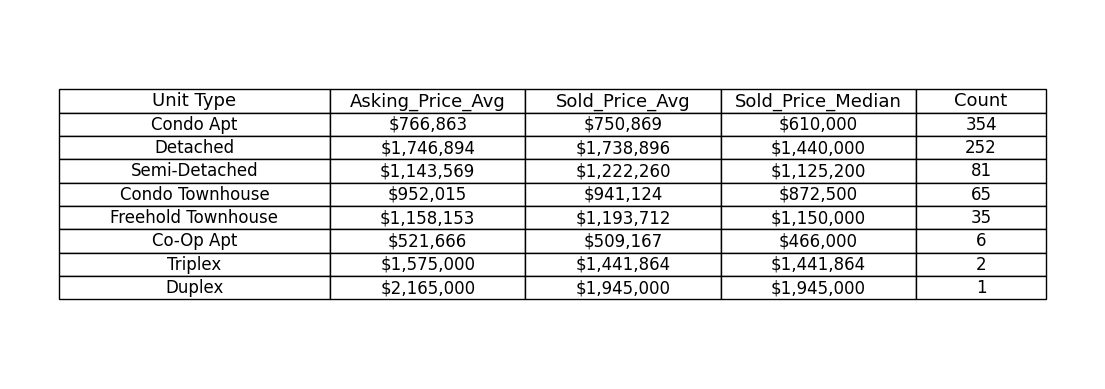

In [290]:
# Adjust the DataFrame to display
df_to_display = avg_prices  # Use your aggregated DataFrame

# Create the figure and axis with larger dimensions
fig, ax = plt.subplots(figsize=(14, len(df_to_display) * 0.6))  # Slightly wider figure
ax.axis('off')  # Hide the axis

# Create the table with improved alignment
table = ax.table(
    cellText=df_to_display.values,
    colLabels=df_to_display.columns,
    loc='center',
    cellLoc='center',        # Center-align cell content
    colLoc='center'          # Center-align column headers
)

# Adjust font size and scale for better fit
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.3, 1.4)  # Slightly increased scaling (width, height)

# Auto-adjust column widths based on content length
col_widths = [0.25, 0.18, 0.18, 0.18, 0.12]  # Adjusted column widths

# Apply column widths
for key, cell in table.get_celld().items():
    cell.set_text_props(ha='center', va='center')  # Center-align text
    if key[0] == 0:  # Header row
        cell.set_fontsize(13)  # Slightly larger font for headers
    if key[1] < len(col_widths):
        cell.set_width(col_widths[key[1]])  # Apply width based on column index

# Save the table as a high-resolution image
plt.savefig("average_prices_table_final.png", bbox_inches='tight', dpi=300)

# Optional: Display the image
plt.show()

##### Save tables as images (png)

In [291]:
scraper.save_table_as_image(
    avg_prices,
    "average_prices_table.png",
    col_widths=[0.25, 0.18, 0.18, 0.18, 0.12]  # Custom widths for 5 columns
)

scraper.save_table_as_image(
    avg_prices_with_count,
    "average_prices_with_bedrooms_table.png",
    col_widths=[0.20, 0.18, 0.10, 0.18, 0.18, 0.18]  # Adjusted widths for 6 columns
)

##### Print unique postal codes and postal code areas

In [292]:
filtered_sold_data_df["Postal Code Area"] = filtered_sold_data_df["Postal Code"].apply(lambda x: x[:3] if pd.notna(x) else "N/A")

print(filtered_sold_data_df['Postal Code'].unique())
print("\n--------")
print(filtered_sold_data_df['Postal Code Area'].unique())

['M4M0A6' 'M4P0C6' 'L4B3C3' 'M5V4A9' 'M9N2G7' 'M5V1B5' 'L4H0N6' 'M2H1G7'
 'M4P1P9' 'M1W3X9' 'M8X1P4' 'L4Z0A4' 'M4Y2K2' 'M2N7C3' 'L4J8M8' 'L5A2X7'
 'M4E3K4' 'M8W3V8' 'M9R0A3' 'L5A3S2' 'M2L1Z9' 'M1L1W3' 'M1M1J3' 'M5T1B7'
 'M1H0A1' 'M1J1M7' 'M5Y1J6' 'M1V4X9' 'M6K0C5' 'M4R1G4' 'M8Y0B6' 'M8V1Y8'
 'M8X2Z8' 'M9P1A7' 'M5J2N4' 'M5V0H8' 'M9M1G3' 'M6K2L9' 'M6E4G7' 'M2M4K8'
 'M5A2N1' 'M4W0B2' 'M1T0B6' 'M2J0B1' 'M4L1P6' 'M1R1J1' 'M4J2P3' 'M4P0E3'
 'L3T1Z1' 'M2H2V2' 'M6G2S8' 'M4L3B6' 'M1W2M1' 'M6H3X8' 'M6C3X9' 'M6K3P9'
 'L4L2A6' 'M9N3W5' 'M9V1Y2' 'M9N3C3' 'M6S2X2' 'M9B1S9' 'M1H1S1' 'M4G0A1'
 'M6P1G7' 'M4S1A5' 'M5G0C5' 'M6S5B3' 'M9C1X6' 'M5M1V2' 'M6N3N9' 'M6P0A8'
 'M6N1M8' 'L4B4S7' 'M6B1K1' 'M6J3B8' 'M5V3X6' 'L3T0B8' 'M5H4G5' 'M2N0G4'
 'M5A0C3' 'L5B4J5' 'M9W6A7' 'L6B0V5' 'M3C0P7' 'M5V4A5' 'M1G0A9' 'L4B4J9'
 'M1S0L7' 'M9A5C4' 'M5E0E3' 'L6A4W6' 'M5B0A5' 'M2K0H2' 'L3R5M5' 'M5R1B3'
 'M2N7E2' 'M4Y0C3' 'M6S4E5' 'M4Y1R9' 'L4W4C7' 'M1B5Z3' 'L5B0N3' 'M1S5B2'
 'L5G2H8' 'M5M1X5' 'M5V0L7' 'M6H4K9' 'M6N1T3' 'M8V0

##### Calculate average and median prices by postal code area

In [293]:
# ✅ Filter the original DataFrame BEFORE aggregation
filtered_data = filtered_sold_data_df[
    (~filtered_sold_data_df["Bedrooms"].isin(["1", "0"])) &  # ✅ Exclude Bedrooms = "1" or "0"
    (filtered_sold_data_df["Count"] > 1 if "Count" in filtered_sold_data_df.columns else True)  # Handle Count if it exists
]

# Group by Postal Code Area after filtering
postal_aggregates = (
    filtered_data.groupby("Postal Code Area")
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

# ✅ Filter out postal codes where Count = 1 AFTER aggregation
postal_aggregates = postal_aggregates[postal_aggregates["Count"] > 1]

# ✅ Sort by Sold_Price_Median in descending order BEFORE formatting
postal_aggregates = postal_aggregates.sort_values(by="Sold_Price_Median", ascending=False)

# Format the average prices, median, and counts for better readability
postal_aggregates["Asking_Price_Avg"] = postal_aggregates["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Sold_Price_Avg"] = postal_aggregates["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Sold_Price_Median"] = postal_aggregates["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
postal_aggregates["Count"] = postal_aggregates["Count"].apply(lambda x: f"{x:,}")

# Display the sorted DataFrame
print(postal_aggregates.to_string(index=False))

Postal Code Area Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
      M4R           $3,131,667      $3,049,667       $3,825,000       3 
      M4V           $3,650,000      $3,687,500       $3,687,500       2 
      M5S           $3,601,667      $3,242,667       $3,620,000       6 
      M5P           $3,341,333      $3,156,667       $3,205,000       3 
      M4G           $2,524,980      $2,446,000       $2,495,000       5 
      M5M           $2,316,857      $2,287,888       $2,327,215       7 
      L6C           $2,103,444      $2,145,400       $2,145,400       2 
      M5N           $2,094,333      $2,036,333       $2,139,000       3 
      M8X           $2,244,000      $2,112,500       $2,112,500       2 
      M5H           $2,094,000      $2,014,500       $2,014,500       2 
      M4T           $2,999,571      $3,031,857       $1,945,000       7 
      M3B           $2,258,800      $2,208,000       $1,814,000       6 
      L3P           $1,574,166      $1,499,967     

In [294]:
# Group by Postal Code Area and Unit Type
postal_unit_aggregates = (
    filtered_sold_data_df.groupby(["Postal Code Area", "Unit Type"])
    .agg(
        Asking_Price_Avg=("Asking Price", "mean"),
        Sold_Price_Avg=("Sold Price", "mean"),
        Sold_Price_Median=("Sold Price", "median"),
        Count=("Asking Price", "count")  # Counting the number of observations
    )
    .reset_index()
)

# Format the average prices, median, and counts for better readability
postal_unit_aggregates["Asking_Price_Avg"] = postal_unit_aggregates["Asking_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Sold_Price_Avg"] = postal_unit_aggregates["Sold_Price_Avg"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Sold_Price_Median"] = postal_unit_aggregates["Sold_Price_Median"].apply(lambda x: f"${x:,.0f}")
postal_unit_aggregates["Count"] = postal_unit_aggregates["Count"].apply(lambda x: f"{x:,}")

# Display the aggregated DataFrame
print(postal_unit_aggregates.to_string(index=False))

Postal Code Area     Unit Type      Asking_Price_Avg Sold_Price_Avg Sold_Price_Median Count
      L3L                  Detached    $2,229,000      $2,040,000       $2,040,000       1 
      L3P                 Condo Apt      $648,000        $605,000         $605,000       1 
      L3P           Condo Townhouse      $899,000        $890,000         $890,000       1 
      L3P                  Detached    $1,974,500      $1,876,200       $1,879,200       4 
      L3R                 Condo Apt      $869,225        $801,125         $774,500       4 
      L3R                  Detached    $1,811,848      $1,847,812       $1,448,500       8 
      L3R             Semi-Detached    $1,229,000      $1,296,900       $1,296,900       2 
      L3S                  Detached    $1,380,457      $1,422,075       $1,238,800       8 
      L3S        Freehold Townhouse      $999,000      $1,093,005       $1,093,005       2 
      L3T                 Condo Apt      $564,655        $562,836         $538,0

In [295]:
# ✅ Set display options for better formatting
pd.set_option('display.max_columns', None)        # Show all columns without truncation
pd.set_option('display.width', 200)               # Increase display width to prevent line breaks
pd.set_option('display.max_colwidth', None)       # Prevent truncation of long text (like addresses)
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

# ✅ Check data for a specific postal code area
select_cols = ["Postal Code Area", "Address", "Bedrooms", "Asking Price", "Sold Price"]
check_area = "M1H"

# ✅ Filter the data
filtered_data = filtered_sold_data_df[filtered_sold_data_df["Postal Code Area"] == check_area][select_cols].copy()
filtered_data = filtered_data[filtered_data['Bedrooms'] != '1']

# ✅ Format dollar values with $ and commas
filtered_data["Asking Price"] = filtered_data["Asking Price"].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")
filtered_data["Sold Price"] = filtered_data["Sold Price"].apply(lambda x: f"${x:,.0f}" if pd.notna(x) else "N/A")

# ✅ Display the data without showing the index
print(filtered_data.to_string(index=False))

Postal Code Area                    Address                     Bedrooms Asking Price Sold Price
      M1H        1611 - 68 Grangeway Ave , Scarborough - Woburn     2      $569,900     $555,000
      M1H                99 Rochman Blvd , Scarborough - Woburn     3      $749,900     $820,000
      M1H               175 Lynnbrook Dr , Scarborough - Woburn   3+3      $999,999   $1,260,000
      M1H         803 - 68 Grangeway Ave , Scarborough - Woburn     2      $559,900     $535,000
      M1H        1205A - 88 Corporate Dr , Scarborough - Woburn     2      $599,000     $590,000


##### Loop through listing URLs to get more info about each listing

In [296]:
# test function save_listing_url_html
test_url = prices_df_temp['Listing URL'][0]
unit_type_test = prices_df_temp['Unit Type'][0]
print(f"\nGetting data for unit {unit_type_test}, URL: {test_url}")


Getting data for unit Condo Apt, URL: https://housesigma.com/on/toronto-real-estate/623-88-colgate-ave/home/DnM697koZNd7bmwe/


##### Test function save_listing_url_html

In [297]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# options = webdriver.ChromeOptions()
# options.add_argument("--disable-blink-features=AutomationControlled")
# options.add_experimental_option("excludeSwitches", ["enable-automation"])
# options.add_experimental_option("useAutomationExtension", False)

# driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# # ✅ Open HouseSigma for manual login
# driver.get("https://housesigma.com")
# input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

# output_filename = "listing_page.html"

# # ✅ Save the full HTML content
# scraper.save_listing_url_html(driver, test_url, output_filename, unit_type_test)

# # ✅ Close the browser after saving
# driver.quit()

##### Loop through listing urls

In [ ]:
print("🔄 Reinitializing WebDriver...")

options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ✅ Open HouseSigma for manual login
driver.get("https://housesigma.com")
input("🔑 Press Enter after logging in manually...")  # ⬅️ Login manually, then press Enter

# ✅ Apply `save_listing_url_html()` correctly with all arguments
extracted_data = prices_df_temp.apply(
    lambda row: scraper.save_listing_url_html(
        driver, row["Listing URL"], row["Unit Type"]
    ),
    axis=1
)

# ✅ Convert the extracted dictionary output into a DataFrame
extracted_df = extracted_data.apply(pd.Series)

# ✅ Close the browser after processing all listings
driver.quit()
print("\n✅ All listings processed. Browser closed.")

🔄 Reinitializing WebDriver...

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/623-88-colgate-ave/home/DnM697koZNd7bmwe/

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/2712-185-roehampton-ave/home/NAKv53D08KW3MnxB/

🚀 Accessing: https://housesigma.com/on/richmond-hill-real-estate/19-dalewood-dr/home/0J6Em7bPdjQYXBeq/

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/3215-21-iceboat-terr-n/home/DnM697ko11g7bmwe/

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/54-william-st/home/oK8OgYBakmz3JmG2/

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/406-21-grand-magazine-st/home/jAXw7QwXDLdYQOzg/

🚀 Accessing: https://housesigma.com/on/vaughan-real-estate/483-davos-rd/home/L5VXv3lNerNyj2q8/

🚀 Accessing: https://housesigma.com/on/north-york-real-estate/11-6-liszt-gate/home/BXeEn7X425K7rPo8/

🚀 Accessing: https://housesigma.com/on/toronto-real-estate/3010-39-roehampton-ave/home/zVwod7vdPq8Y5mGN/

🚀 Accessing: https://housesigma.com/on/sc

C:\Users\USER\AppData\Local\Temp\ipykernel_12404\512517537.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  extracted_df["Sale Date"].fillna("N/A", inplace=True)



✅ All listings processed. Browser closed.


###### Check results

In [ ]:
print(extracted_df.shape)
print("\n" + "=" * 50)  # Separator line
print(extracted_df.head())

# ✅ Convert "Sold Days Ago" into "Sale Date"
extracted_df["Sold Days Ago"] = pd.to_numeric(extracted_df["Sold Days Ago"], errors="coerce")
extracted_df["Sale Date"] = (pd.to_datetime("today") - pd.to_timedelta(extracted_df["Sold Days Ago"], unit="D")).dt.strftime("%Y-%m-%d")
extracted_df["Sale Date"] = extracted_df["Sale Date"].fillna("N/A")

print("\n" + "=" * 50)  # Separator line
print(extracted_df.shape)
print(extracted_df.head())

(20, 4)

   Sold Days Ago Maintenance Fees  \
0       17          $708/month      
1        8          $451/month      
2        9                 N/A      
3        9          $587/month      
4        9                 N/A      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

C:\Users\USER\AppData\Local\Temp\ipykernel_12404\605378515.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  extracted_df["Sale Date"].fillna("N/A", inplace=True)
